# Multi-Site Meteorological Analysis (Specific Experiment Windows)

**Objective:** Extract weather conditions for specific chamber experiment durations.
**Method:** 
1. Fetch full-day hourly data from NOAA/Meteostat.
2. Filter data to match the specific Start/End times of each experiment.
3. Calculate Stability Class and averages for the specific window.
4. Visualize full-day wind context vs. specific experiment summary.

In [15]:
# IMPORTS & CONFIGURATION
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from meteostat import Point, Hourly, Stations
from windrose import WindroseAxes

In [16]:
# --- User Inputs: Specific Time Windows ---
SITES = {
    "Landfill 19": {
        "lat": 34.3645, 
        "lon": -77.9940,
        "experiments": [
            {"date": "2022-03-30", "start": "14:10", "end": "15:12"},
            {"date": "2022-04-28", "start": "14:03", "end": "14:46"},
            {"date": "2021-08-18", "start": "14:44", "end": "16:46"}
        ]
    },
    "Landfill 26": {
        "lat": 35.7796, 
        "lon": -78.6382,
        "experiments": [
            {"date": "2022-05-03", "start": "10:10", "end": "11:04"},
            {"date": "2021-09-15", "start": "13:36", "end": "16:06"},
            {"date": "2021-11-03", "start": "11:28", "end": "12:30"}
        ]
    }
}

# --- Aesthetics ---
COLOR_LIST = ["#708090", "#5D8AA8", "#66CDAA", "#36454F"]
CUSTOM_CMAP = mcolors.LinearSegmentedColormap.from_list("minimalist", COLOR_LIST)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 9

### Funtions

In [17]:
# SCIENTIFIC FUNCTIONS (Stability & Geometry)
def calculate_solar_elevation(lat, day_of_year, hour):
    """Calculates Solar Elevation Angle (degrees)."""
    delta = 23.45 * math.sin(math.radians(360/365 * (day_of_year - 81)))
    H = 15 * (hour - 12)
    
    lat_rad = math.radians(lat)
    delta_rad = math.radians(delta)
    H_rad = math.radians(H)
    
    sin_beta = (math.sin(lat_rad) * math.sin(delta_rad)) + \
               (math.cos(lat_rad) * math.cos(delta_rad) * math.cos(H_rad))
    
    return math.degrees(math.asin(sin_beta))

def determine_stability(row, lat):
    """Estimates Pasquill-Gifford Class based on Wind Speed (m/s) + Insolation."""
    ws_ms = row['wspd']
    dt = row.name
    
    # 1. Insolation
    day_of_year = dt.timetuple().tm_yday
    elevation = calculate_solar_elevation(lat, day_of_year, dt.hour)
    
    insolation = 'Weak'
    if elevation > 60: insolation = 'Strong'
    elif 35 <= elevation <= 60: insolation = 'Moderate'
    elif elevation < 35: insolation = 'Slight'
    
    # 2. Night/Cloud Checks
    coco_val = row['coco'] if 'coco' in row and not pd.isna(row['coco']) else 0
    
    if elevation <= 0:
        return 'E' if ws_ms < 3 else 'D'
    elif coco_val >= 7:
        return 'D'
        
    # 3. Daytime Matrix
    if ws_ms < 2:
        return {'Strong': 'A', 'Moderate': 'B', 'Slight': 'B'}[insolation]
    elif 2 <= ws_ms < 3:
        return {'Strong': 'A', 'Moderate': 'B', 'Slight': 'C'}[insolation]
    elif 3 <= ws_ms < 5:
        return {'Strong': 'B', 'Moderate': 'B', 'Slight': 'C'}[insolation]
    elif 5 <= ws_ms < 6:
        return {'Strong': 'C', 'Moderate': 'C', 'Slight': 'D'}[insolation]
    else:
        return {'Strong': 'C', 'Moderate': 'D', 'Slight': 'D'}[insolation]

In [18]:
# DATA FETCHING UTILITIES
def fetch_and_process_experiment(site_name, config):
    """Fetches data for specific experiment windows."""
    lat, lon = config['lat'], config['lon']
    experiments = config['experiments']
    
    # Locate Station
    stations = Stations().nearby(lat, lon)
    station = stations.fetch(1)
    print(f"[{site_name}] Station: {station.iloc[0]['name']} ({station.iloc[0]['distance']/1000:.1f} km)")
    
    window_data = []
    full_day_data = [] # For wind rose context

    for exp in experiments:
        date_str = exp['date']
        start_time_str = exp['start']
        end_time_str = exp['end']
        
        # Construct Datetime objects
        # Fetching covers the whole day to ensure we catch the relevant hours
        fetch_start = datetime.strptime(date_str, '%Y-%m-%d')
        fetch_end = fetch_start.replace(hour=23, minute=59)
        
        # Parse experiment bounds for filtering
        exp_start_dt = datetime.strptime(f"{date_str} {start_time_str}", '%Y-%m-%d %H:%M')
        exp_end_dt = datetime.strptime(f"{date_str} {end_time_str}", '%Y-%m-%d %H:%M')
        
        # Fetch Hourly Data (Full Day)
        data = Hourly(station.index[0], fetch_start, fetch_end).fetch()
        
        if not data.empty:
            # Basic Prep
            data['date_str'] = date_str
            if 'wspd' in data.columns: data['wspd'] = data['wspd'] / 3.6 # km/h to m/s
            data['stability_class'] = data.apply(lambda row: determine_stability(row, lat), axis=1)
            data['Site'] = site_name
            
            # Store Full Day for Plots
            full_day_data.append(data)
            
            # Filter for Specific Window (Include hours that touch the interval)
            # Logic: Keep rows where hour is >= start_hour AND <= end_hour
            start_hour = exp_start_dt.hour
            end_hour = exp_end_dt.hour
            if exp_end_dt.minute > 0: 
                # If it ends at 10:05, we typically include the 10:00-11:00 hour block
                pass 

            mask = (data.index.hour >= start_hour) & (data.index.hour <= end_hour)
            sliced = data[mask].copy()
            
            if not sliced.empty:
                sliced['Window_Start'] = start_time_str
                sliced['Window_End'] = end_time_str
                window_data.append(sliced)
            
    df_window = pd.concat(window_data) if window_data else pd.DataFrame()
    df_full = pd.concat(full_day_data) if full_day_data else pd.DataFrame()
    
    return df_window, df_full

In [19]:
all_window_data = []
all_full_data = []

for site_name, config in SITES.items():
    w_df, f_df = fetch_and_process_experiment(site_name, config)
    if not w_df.empty: all_window_data.append(w_df)
    if not f_df.empty: all_full_data.append(f_df)

master_window_df = pd.concat(all_window_data) if all_window_data else pd.DataFrame()
master_full_df = pd.concat(all_full_data) if all_full_data else pd.DataFrame()

# Generate Summary Table based on WINDOW data
if not master_window_df.empty:
    summary = master_window_df.groupby(['Site', 'date_str', 'Window_Start', 'Window_End']).agg({
        'wdir': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
        'wspd': 'mean',
        'temp': 'mean',
        'stability_class': lambda x: x.mode()[0] if not x.mode().empty else 'D'
    }).reset_index()

    summary['wspd'] = summary['wspd'].round(2)
    summary['temp'] = summary['temp'].round(1)
    summary.rename(columns={
        'date_str': 'Date',
        'wdir': 'Dir (deg)',
        'wspd': 'Avg Speed (m/s)',
        'temp': 'Avg Temp (C)',
        'stability_class': 'Stability'
    }, inplace=True)
else:
    print("No Data Available")

[Landfill 19] Station: Wilmington / The Palms Mobile Home Park (13.4 km)
[Landfill 26] Station: Raleigh-Durham International  Airport (17.7 km)


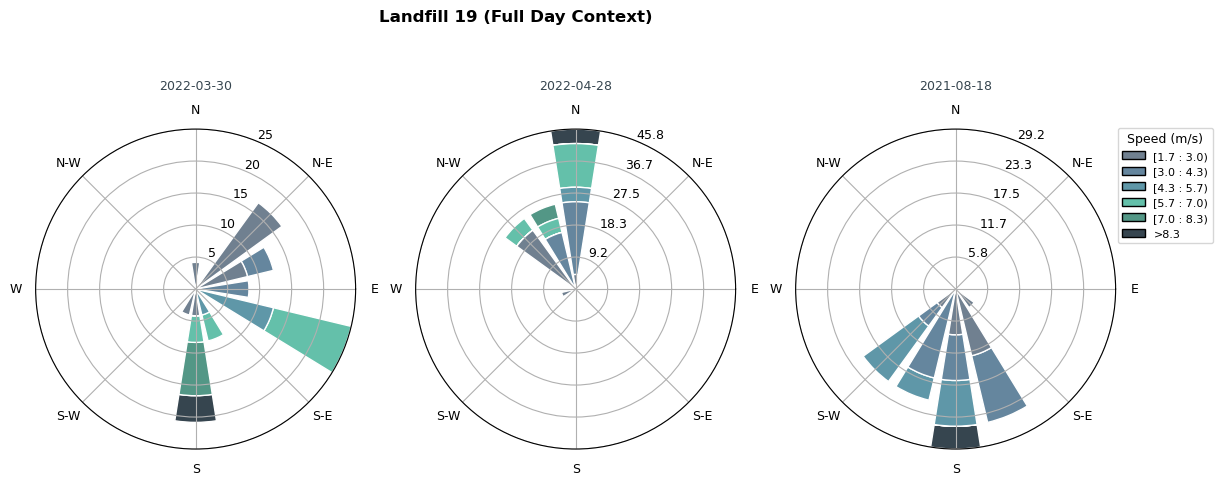

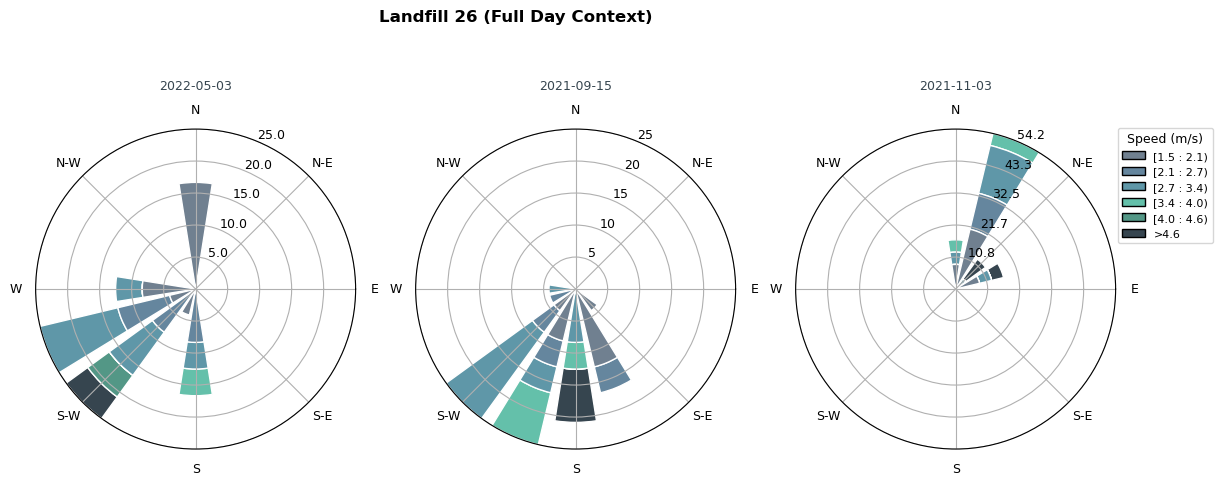

In [20]:
#VISUALIZATION (Full Day Context)
if not master_full_df.empty:
    for site_name in SITES.keys():
        # Filter full day data for this site
        site_data = master_full_df[master_full_df['Site'] == site_name]
        unique_dates = site_data['date_str'].unique()
        
        if len(unique_dates) == 0: continue

        # Create Figure
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f"{site_name} (Full Day Context)", fontsize=12, y=1.2, fontweight='bold')

        for i, date_str in enumerate(unique_dates):
            day_data = site_data[site_data['date_str'] == date_str]
            
            width = 0.8 / len(unique_dates)
            left = 0.1 + (i * width) + (i * 0.05)
            
            if not day_data.empty:
                rect = [left, 0.1, width, 0.8] 
                ax = WindroseAxes(fig, rect)
                fig.add_axes(ax)
                ax.bar(day_data['wdir'], day_data['wspd'], normed=True, 
                       opening=0.8, edgecolor='white', cmap=CUSTOM_CMAP)
                ax.set_title(f"{date_str}", fontsize=9, color='#36454F', pad=10)
                
                if i == len(unique_dates) - 1:
                    ax.set_legend(title="Speed (m/s)", loc='best', 
                                  bbox_to_anchor=(1.3, 1), fontsize=8)
        plt.show()

In [21]:
#FINAL REPORT (Specific Windows)
print(f"### Experiment Window Conditions")
summary

### Experiment Window Conditions


,Site,Date,Window_Start,Window_End,Dir (deg),Avg Speed (m/s),Avg Temp (C),Stability
0,Landfill 19,2021-08-18,14:44,16:46,180.0,4.72,29.3,C
1,Landfill 19,2022-03-30,14:10,15:12,110.0,5.0,18.0,B
2,Landfill 19,2022-04-28,14:03,14:46,10.0,5.28,18.0,C
3,Landfill 26,2021-09-15,13:36,16:06,200.0,3.36,25.8,B
4,Landfill 26,2021-11-03,11:28,12:30,20.0,1.81,7.2,B
5,Landfill 26,2022-05-03,10:10,11:04,230.0,2.36,18.9,A


In [22]:
summary.to_dict()

{'Site': {0: 'Landfill 19',
  1: 'Landfill 19',
  2: 'Landfill 19',
  3: 'Landfill 26',
  4: 'Landfill 26',
  5: 'Landfill 26'},
 'Date': {0: '2021-08-18',
  1: '2022-03-30',
  2: '2022-04-28',
  3: '2021-09-15',
  4: '2021-11-03',
  5: '2022-05-03'},
 'Window_Start': {0: '14:44',
  1: '14:10',
  2: '14:03',
  3: '13:36',
  4: '11:28',
  5: '10:10'},
 'Window_End': {0: '16:46',
  1: '15:12',
  2: '14:46',
  3: '16:06',
  4: '12:30',
  5: '11:04'},
 'Dir (deg)': {0: 180.0, 1: 110.0, 2: 10.0, 3: 200.0, 4: 20.0, 5: 230.0},
 'Avg Speed (m/s)': {0: 4.72, 1: 5.0, 2: 5.28, 3: 3.36, 4: 1.81, 5: 2.36},
 'Avg Temp (C)': {0: 29.3, 1: 18.0, 2: 18.0, 3: 25.8, 4: 7.2, 5: 18.9},
 'Stability': {0: 'C', 1: 'B', 2: 'C', 3: 'B', 4: 'B', 5: 'A'}}

In [ ]:
import json

# Convert summary DataFrame to structured JSON format
json_output = {
    "metadata": {
        "analysis_window": "Specific Experiment Windows",
        "sites": list(SITES.keys())
    },
    "summary": {
        "by_site_and_date": []
    },
    "statistics": {
        "total_observations": len(summary),
        "sites_analyzed": summary['Site'].unique().tolist(),
        "date_range": {
            "earliest": summary['Date'].min(),
            "latest": summary['Date'].max()
        }
    }
}

# Add each experiment window as a structured record
for _, row in summary.iterrows():
    record = {
        "Site": row['Site'],
        "Date": row['Date'],
        "Time_window": {
            "Start": row['Window_Start'],
            "End": row['Window_End']
        },
        "meteorological_conditions": {
            "Wind_direction_deg": float(row['Dir (deg)']),
            "Wind_speed_ms": float(row['Avg Speed (m/s)']),
            "Temperature_c": float(row['Avg Temp (C)']),
            "Stability_class": row['Stability']
        }
    }
    json_output["summary"]["by_site_and_date"].append(record)

# Display formatted JSON
print(json.dumps(json_output, indent=4))

# Optionally save to file
with open('meteorological_summary.json', 'w') as f:
    json.dump(json_output, f, indent=4)